<a href="https://colab.research.google.com/github/ericyoc/quantum-circuit-anomaly-detection/blob/main/quant_anamaly_det_pennylane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install required libraries
#!pip install pennylane tensorflow numpy matplotlib tabulate

In [5]:
# Import necessary modules
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

Without Quantum Anomaly Detection:


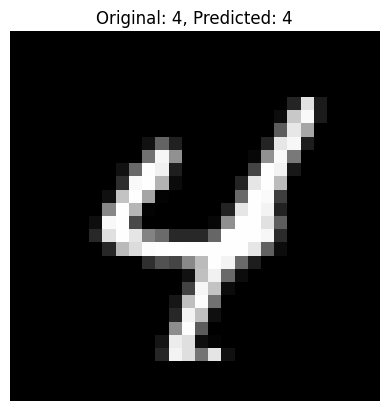

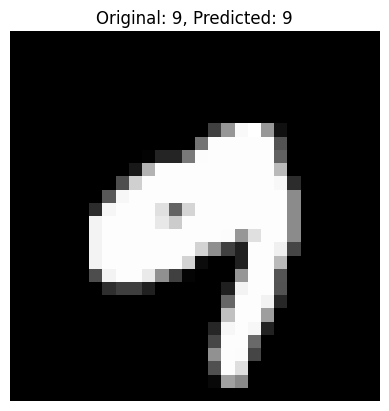

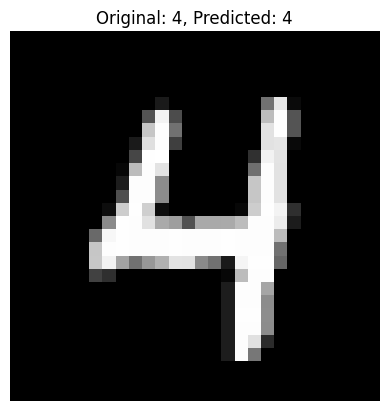

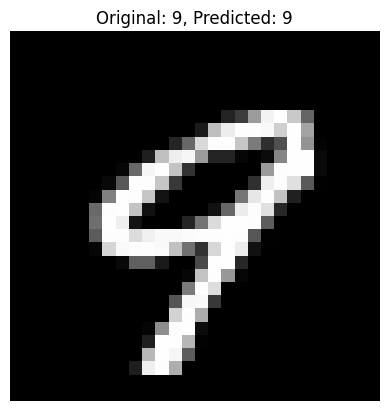

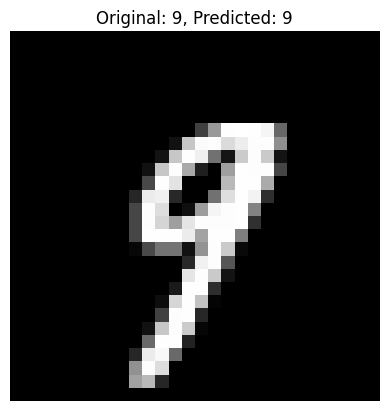


With Quantum Anomaly Detection:


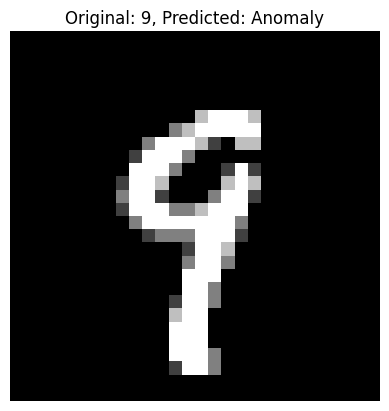

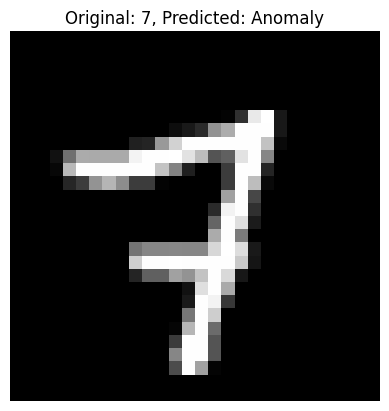

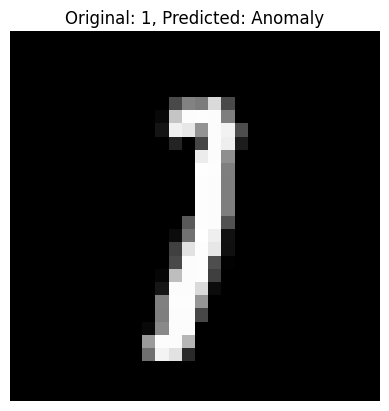

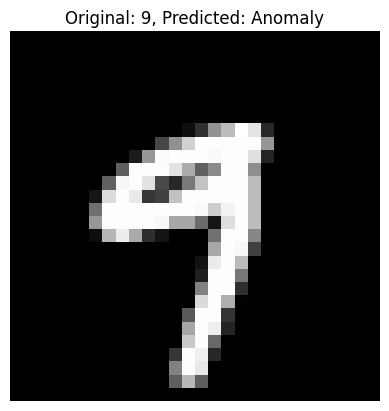

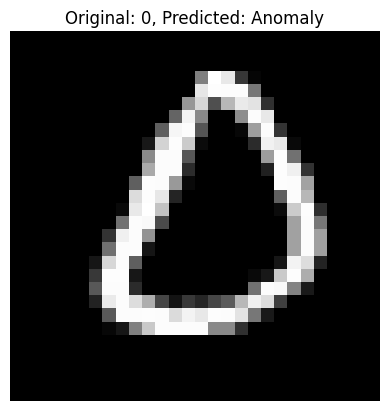


Comparison Table (Number of Qubits: 16):
+---------+------------------+-------------------------------------+----------------------------------+-----------------+
|   Image |   Original Label |   Predicted Label (Without Anomaly) | Predicted Label (With Anomaly)   |   Anomaly Score |
+=========+==================+=====================================+==================================+=================+
|       1 |                4 |                                   4 | Anomaly                          |        0.99997  |
+---------+------------------+-------------------------------------+----------------------------------+-----------------+
|       2 |                9 |                                   9 | Anomaly                          |        0.999399 |
+---------+------------------+-------------------------------------+----------------------------------+-----------------+
|       3 |                4 |                                   4 | Anomaly                          | 

In [8]:
# Load and preprocess the MNIST dataset with memory-efficient data loading
def load_and_preprocess_data(batch_size):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype(np.float64) / 255.0
    x_test = x_test.astype(np.float64) / 255.0

    # Reshape the data to include a channel dimension
    x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
    x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

    # Create data generators for memory-efficient loading
    train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator()
    train_data_gen.fit(x_train)

    test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator()
    test_data_gen.fit(x_test)

    # Generate batches of data
    train_data = train_data_gen.flow(x_train, y_train, batch_size=batch_size)
    test_data = test_data_gen.flow(x_test, y_test, batch_size=batch_size)

    return train_data, test_data

def quantum_anomaly_detection_circuit(data, num_qubits, noise_probability=0.1):
    # Convert data to a numpy array if it's not already
    if not isinstance(data, np.ndarray):
        data = np.array(data)

    # Flatten the data if it's a multi-dimensional array
    data = data.flatten()

    # Truncate or pad the data to match the number of qubits
    if data.shape[0] > num_qubits:
        data = data[:num_qubits]
    else:
        data = np.pad(data, (0, num_qubits - data.shape[0]), mode='constant')

    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def circuit(data):
        # Encode the data into the quantum circuit
        for i in range(num_qubits):
            angle = data[i] * np.pi  # Scale the data to the range [0, pi]
            qml.RY(angle, wires=i)

        # Apply a Hadamard gate to each qubit
        for i in range(num_qubits):
            qml.Hadamard(wires=i)

        # Apply noise to simulate an adversarial attack
        for i in range(num_qubits):
            if np.random.rand() < noise_probability:
                # Apply a random rotation around the Y-axis as noise
                noise_angle = np.random.uniform(0, 2 * np.pi)
                qml.RY(noise_angle, wires=i)

        # Measure the probabilities of each computational basis state
        return qml.probs(wires=range(num_qubits))

    return circuit(data)

# Define the quantum anomaly detection model
def quantum_anomaly_detection_model(data, num_qubits, batch_size=32):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    data = data.flatten()

    anomaly_scores = []
    for i in range(0, data.shape[0], batch_size):
        batch_data = data[i:i+batch_size]
        probs = quantum_anomaly_detection_circuit(batch_data, num_qubits)

        # Calculate the anomaly score based on the non-zero probabilities
        non_zero_probs = probs[1:]  # Exclude the zero state probability
        batch_anomaly_scores = np.sum(non_zero_probs)
        anomaly_scores.append(batch_anomaly_scores)

    anomaly_score = np.mean(anomaly_scores)
    return anomaly_score

# Test the model without quantum anomaly detection
def test_without_quantum_anomaly_detection(test_data, num_samples):
    print("Without Quantum Anomaly Detection:")
    results = []
    for i in range(num_samples):
        image_batch, label_batch = next(test_data)
        image = image_batch[0]
        label = label_batch[0]
        predicted_label = label  # Use the original label as the predicted label
        results.append({"Image": i+1, "Original Label": label, "Predicted Label": predicted_label, "Anomaly Score": "-"})

        plt.imshow(image.reshape((28, 28)), cmap='gray')
        plt.title(f"Original: {label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

    return results

# Test the model with quantum anomaly detection
def test_with_quantum_anomaly_detection(test_data, num_samples, num_qubits, threshold, batch_size):
    print("\nWith Quantum Anomaly Detection:")
    results = []
    for i in range(num_samples):
        image_batch, label_batch = next(test_data)
        image = image_batch[0].flatten()
        label = label_batch[0]
        anomaly_score = quantum_anomaly_detection_model(image, num_qubits, batch_size)
        predicted_label = np.argmax(image) if anomaly_score < threshold else "Anomaly"
        results.append({"Image": i+1, "Original Label": label, "Predicted Label": predicted_label, "Anomaly Score": anomaly_score})

        plt.imshow(image.reshape((28, 28)), cmap='gray')
        plt.title(f"Original: {label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

    return results

# Function to print the comparison table
def print_comparison_table(without_anomaly_results, with_anomaly_results, num_qubits):
    headers = ["Image", "Original Label", "Predicted Label (Without Anomaly)", "Predicted Label (With Anomaly)", "Anomaly Score"]
    table_data = []
    for i in range(len(without_anomaly_results)):
        table_data.append([
            without_anomaly_results[i]["Image"],
            without_anomaly_results[i]["Original Label"],
            without_anomaly_results[i]["Predicted Label"],
            with_anomaly_results[i]["Predicted Label"],
            with_anomaly_results[i]["Anomaly Score"]
        ])

    print(f"\nComparison Table (Number of Qubits: {num_qubits}):")
    print(tabulate(table_data, headers, tablefmt="grid"))

# Main function
def main():
    # Install required libraries
    # !pip install pennylane tensorflow numpy matplotlib tabulate

    # Set parameters
    batch_size = 32
    num_samples = 5
    num_qubits = 16  # Specify the desired number of qubits
    threshold = 0.5
    noise_probability = 0.1  # Specify the probability of applying noise to each qubit

    # Load and preprocess the data
    train_data, test_data = load_and_preprocess_data(batch_size)

    # Test the model without quantum anomaly detection
    without_anomaly_results = test_without_quantum_anomaly_detection(test_data, num_samples)

    # Test the model with quantum anomaly detection
    with_anomaly_results = test_with_quantum_anomaly_detection(test_data, num_samples, num_qubits, threshold, batch_size)

    # Print the comparison table
    print_comparison_table(without_anomaly_results, with_anomaly_results, num_qubits)


if __name__ == "__main__":
    main()